## Individual-based model (Polechova and Barton, 2015)

In [1]:
using Random, Distributions, Plots

In [2]:
#global variables cfr. table 1

rm = 1.025 #maximum intrinsic growth rate
Vs = 2 #variance of stabilising selection 

b = 0.1 #gradient in the environmental optimum
σ = sqrt(0.5) #dispersal per generation
K = 300 #carrying capacity for a well-adapted phenotype
#α = 1/sqrt(20) #allelic effect
α = 0.0001
μ = 10^-6 #mutation rate
T = 5000 #number of generations 
h_ = 1 # ??

1

In [3]:
num_demes(σ,Vs,α) = round(Int64,10*4*sqrt(σ^2*Vs)/α)
num_loci(nd,b,α) = round(Int64,nd*b/α)
num_ind(K,b,σ,h,Vs,rm) = round(Int64,K*((1-b*σ)/(2*h^2*sqrt(Vs)*rm)))

num_ind (generic function with 1 method)

In [4]:
nd = num_demes(σ,Vs,α)

400000

In [5]:
nl = num_loci(nd,b,α)

400000000

In [6]:
#nn = num_ind(K,b,σ,h_,Vs,rm)

In [7]:
nn = 100

100

In [8]:
mutable struct Agent{T}
    loci::Vector{T}
end

Note: allele effect size ? -> L bi-allelic loci underlying trait x, allele effect size 0 or α -> trait = sum of allele effect sizes over all loci


In [9]:
pushlocus!(a::Agent, x) = push!(a.loci, x)

pushlocus! (generic function with 1 method)

In [10]:
#generate N haploid individuals with L loci and two possible allele-effect sizes α or 0
function make_agents(N,L,α)
    pop = [Agent(α .* rand(Bool, L)) for i in 1:N]
    return pop
end

make_agents (generic function with 1 method)

In [11]:
agents = make_agents(10,10,α)

10-element Array{Agent{Float64},1}:
 Agent{Float64}([0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0001, 0.0001])
 Agent{Float64}([0.0001, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0001])
 Agent{Float64}([0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0])
 Agent{Float64}([0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0001, 0.0001])
 Agent{Float64}([0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0])
 Agent{Float64}([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0])
 Agent{Float64}([0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001])
 Agent{Float64}([0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0])
 Agent{Float64}([0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0001])
 Agent{Float64}([0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0001])

In [12]:
struct Deme{A,T}
    agents::Vector{A}
    carrying_capacity::Int64
    optimal_phenotype::T 
end

In [13]:
d = Deme(agents, 100, 0.0)

Deme{Agent{Float64},Float64}(Agent{Float64}[Agent{Float64}([0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0001, 0.0001]), Agent{Float64}([0.0001, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0001]), Agent{Float64}([0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0]), Agent{Float64}([0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0, 0.0001, 0.0001, 0.0001, 0.0001]), Agent{Float64}([0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0]), Agent{Float64}([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0]), Agent{Float64}([0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001]), Agent{Float64}([0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0]), Agent{Float64}([0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0001]), Agent{Float64}([0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0001])], 100, 0.0)

In [14]:
Base.length(d::Deme) = length(d.agents)
Base.show(io::IO, d::Deme{A,T}) where {A,T} = write(io, "Deme{$A,$T}(N=$(length(d)))")
Base.push!(d::Deme, a::Agent) = push!(d.agents, a)

In [15]:
push!(d, Agent(1 .* rand(Bool, 10)))
d

LoadError: MethodError: Cannot `convert` an object of type 
  Agent{Int64} to an object of type 
  Agent{Float64}
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T at essentials.jl:171
  Agent{Float64}(::Any) where T at In[8]:2

In [16]:
struct Habitat{T}
    demes::Vector{T}
end

In [17]:
#generate a single deme with population of size N, L loci, α allelic effect, carrying capacity K and optimal phenotype θ
function make_deme(N,L,α,K,θ)
    pop = make_agents(N,L,α)
    return Deme(pop,K,θ)
end
    

make_deme (generic function with 1 method)

In [18]:
w = make_deme(5,2,1,150,10)

Deme{Agent{Int64},Int64}(N=5)

In [19]:
function pop_size(d::Deme)
    return length(d.agents)
end

pop_size (generic function with 1 method)

In [20]:
pop_size(w)

5

In [21]:
#generate a linear 1D habitat of x demes with equal pop size (in paper the pop starts in center of habitat)
function make_habitat(x,N,L,α,K,θ)
    hab = [make_deme(N,L,α,K,θ) for i in 1:x]
    return Habitat(hab)
end

make_habitat (generic function with 1 method)

In [22]:
Base.push!(h::Habitat, d::Deme) = push!(h.demes, d)

In [23]:
function linear_gradient(x,b)
    KK = [i*b for i in 0:x-1]
    return KK
end

linear_gradient (generic function with 1 method)

In [24]:
g = linear_gradient(nd,b)

400000-element Array{Float64,1}:
     0.0
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6000000000000001
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     ⋮
 39998.8
 39998.9
 39999.0
 39999.100000000006
 39999.200000000004
 39999.3
 39999.4
 39999.5
 39999.600000000006
 39999.700000000004
 39999.8
 39999.9

In [25]:
function make_habitat(x,N,L,α,K,θ::Vector{T})
    hab = Habitat([])
    for i in g
        deme = make_deme(0,0,α,K,i)
        push!(hab,deme)
    end
    return hab
end

make_habitat (generic function with 2 methods)

In [26]:
hab = Habitat([])
for i in g
    deme = make_deme(0,0,α,K,i)
    push!(hab,deme)
end

In [27]:
hab.demes[10].optimal_phenotype

0.9

In [28]:
h_g = make_habitat(nd,0,0,α,K,g)

Habitat{Deme{Agent{Float64},Array{Float64,1}}}(Deme{Agent{Float64},Array{Float64,1}}[Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0)  …  Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0), Deme{Agent{Float64},Array{Float64,1}}(N=0)])

In [29]:
h_g.demes[1].optimal_phenotype

400000-element Array{Float64,1}:
     0.0
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6000000000000001
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     ⋮
 39998.8
 39998.9
 39999.0
 39999.100000000006
 39999.200000000004
 39999.3
 39999.4
 39999.5
 39999.600000000006
 39999.700000000004
 39999.8
 39999.9

In [30]:
h = make_habitat(5,5,2,1,150,10)

Habitat{Deme{Agent{Int64},Int64}}(Deme{Agent{Int64},Int64}[Deme{Agent{Int64},Int64}(N=5), Deme{Agent{Int64},Int64}(N=5), Deme{Agent{Int64},Int64}(N=5), Deme{Agent{Int64},Int64}(N=5), Deme{Agent{Int64},Int64}(N=5)])

In [31]:
Base.length(h::Habitat) = length(h.demes)
Base.show(io::IO, h::Habitat) = write(io, 
    "Habitat (n=$(length(h))):\n  $(join(string.(h.demes), "\n  "))")

In [32]:
h

Habitat (n=5):
  Deme{Agent{Int64},Int64}(N=5)
  Deme{Agent{Int64},Int64}(N=5)
  Deme{Agent{Int64},Int64}(N=5)
  Deme{Agent{Int64},Int64}(N=5)
  Deme{Agent{Int64},Int64}(N=5)

In [33]:
#habitat with 7 demes and starting pop in central deme
h = make_habitat(7,0,0,0,150,10)
p = make_agents(3,3,1)
push!(h.demes[4].agents, agents ...)
h

LoadError: MethodError: Cannot `convert` an object of type 
  Agent{Float64} to an object of type 
  Agent{Int64}
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T at essentials.jl:171
  Agent{Int64}(::Any) where T at In[8]:2

## Migration

In [34]:
#should be diffusive migration with a Gaussian dispersal kernel (truncated at 2 SD)
emptycopy(a::Agent{L}) where L = Agent(L[])
emptycopy(d::Deme{A}) where A = Deme(A[], d.carrying_capacity, d.optimal_phenotype)
emptycopy(h::Habitat) = Habitat(emptycopy.(h.demes))

function migrate(h::Habitat, p)
    new_h = emptycopy(h)
    for (i, deme) in enumerate(h.demes)
        for agent in deme.agents
            step = rand() < p ? rand([-1,1]) : 0 
            if step == -1 && i == 1
                step = 0
            elseif step == 1  && i == length(h)
                step = 0
            end
            push!(new_h.demes[i+step], agent)
        end
    end
    new_h
end

migrate (generic function with 1 method)

In [35]:
for i=1:5
    h = migrate(h, 0.2)
    @show h
end

LoadError: UndefRefError: access to undefined reference

## Selection

In [36]:
a = Agent(1.0 .* rand(Bool, 10))

Agent{Float64}([1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0])

In [37]:
phenotype(a::Agent) = sum(a.loci)
phenotype(a)

8.0

In [38]:
Base.sum(a::Agent) = sum(a.loci)
sum(a)

8.0

In [39]:
function malthusian_fitness(d::Deme,a::Agent,rm,Vs)
    N = length(d)
    K = d.carrying_capacity
    θ = d.optimal_phenotype
    z = sum(a)
    return rm*(1-(N/K))-((z-θ)^2)/(2*Vs)
end   

malthusian_fitness (generic function with 1 method)

In [40]:
d = make_deme(nn,1,α,nn,α/2)

Deme{Agent{Float64},Float64}(N=100)

In [41]:
number_of_offspring(d::Deme,a::Agent,rm,Vs) = rand(Poisson(exp(malthusian_fitness(d::Deme,a::Agent,rm,Vs))))

number_of_offspring (generic function with 1 method)

In [42]:
for agent in d.agents
    @show number_of_offspring(d,agent,rm,Vs)
end

number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 2
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 6
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 2
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 4
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 2
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 0
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 1
number_of_offspring(d, agent, rm, Vs) = 3
number_of_offspring(d, agent, rm, 

In [43]:
function replicate(d::Deme)
    new_d_sel = emptycopy(d)
    for agent in d.agents
        numb = number_of_offspring(d,agent,rm,Vs)
        
        for i in 1:numb
            push!(new_d_sel,agent)
        end
    end
    new_d_sel
end

replicate (generic function with 1 method)

In [44]:
replicate(d)

Deme{Agent{Float64},Float64}(N=109)

## Mutation

In [45]:
a

Agent{Float64}([1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0])

In [46]:
function mutate(a::Agent,μ)
   #each allele in a.loci has probability of mu to flip 
    empty_agent = emptycopy(a)
    for x in a.loci
        if rand() > μ
            pushlocus!(empty_agent,x)
        else
            x == 0.0 ? x = α : x = 0.0
            pushlocus!(empty_agent,x)
        end
    end
    empty_agent
end

mutate (generic function with 1 method)

In [47]:
for i=1:5
    a = mutate(a, 0.5)
    @show a
end

a = Agent{Float64}([1.0, 1.0, 1.0, 0.0001, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])
a = Agent{Float64}([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0001, 0.0])
a = Agent{Float64}([0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0001])
a = Agent{Float64}([0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])
a = Agent{Float64}([0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.0001, 0.0001, 0.0, 0.0])


In [48]:
function mutate(d::Deme,μ)
    new_d_mut = emptycopy(d)
    for agent in d.agents
        m_agent = mutate(agent,μ)
        push!(new_d_mut,m_agent)
    end
    new_d_mut
end

mutate (generic function with 2 methods)

In [49]:
d = make_deme(nn,1,α,nn,α/2)
mutate(d,μ)


Deme{Agent{Float64},Float64}(N=100)

In [50]:
for i=1:5
    d = mutate(d, 0.5)
    @show d
end

d = Deme{Agent{Float64},Float64}(N=100)
d = Deme{Agent{Float64},Float64}(N=100)
d = Deme{Agent{Float64},Float64}(N=100)
d = Deme{Agent{Float64},Float64}(N=100)
d = Deme{Agent{Float64},Float64}(N=100)


In [51]:
d = replicate(d)
d = mutate(d)

LoadError: MethodError: no method matching mutate(::Deme{Agent{Float64},Float64})
Closest candidates are:
  mutate(::Deme, !Matched::Any) at In[48]:1
  mutate(!Matched::Agent, !Matched::Any) at In[46]:1

## Recombination

In [52]:
#unlinked loci, r = 0.5
function recombine(a::Agent,b::Agent)
    empty_agent_1 = emptycopy(a)
    empty_agent_2 = emptycopy(a)
    for i in 1:length(a.loci)
        r = rand()
        r > 0.5 ? pushlocus!(empty_agent_1,a.loci[i]) : pushlocus!(empty_agent_1,b.loci[i])
        r > 0.5 ? pushlocus!(empty_agent_2,b.loci[i]) : pushlocus!(empty_agent_2,a.loci[i])
 
    end
    empty_agent_1, empty_agent_2
end
    

recombine (generic function with 1 method)

In [53]:
aa = Agent([1.0 for i in 1:10])
bb = Agent([0.0 for i in 1:10])

Agent{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [54]:
for i=1:5
    aa, bb = recombine(aa, bb)
    @show aa, bb
end

(aa, bb) = (Agent{Float64}([1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), Agent{Float64}([0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]))
(aa, bb) = (Agent{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]), Agent{Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]))
(aa, bb) = (Agent{Float64}([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]), Agent{Float64}([1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]))
(aa, bb) = (Agent{Float64}([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]), Agent{Float64}([1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]))
(aa, bb) = (Agent{Float64}([0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]), Agent{Float64}([1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]))


## Random mating

In [55]:
#random mating function -> pick 2 random agents from deme
function random_mating(d::Deme)
    new_deme = emptycopy(d)
    nodes = d.agents
    while length(nodes) > 1
        shuffle!(nodes)
        n1 = pop!(nodes)
        n2 = pop!(nodes)
        nr = recombine(n1,n2)
        push!(new_deme,nr[1])
        push!(new_deme,nr[2])
    end
    new_deme
end   
        
    

random_mating (generic function with 1 method)

In [56]:
d = make_deme(nn,1,α,nn,α/2)
random_mating(d)

Deme{Agent{Float64},Float64}(N=100)

## Initiation


In [85]:
function life_cycle(d::Deme)
    new_d_sel = replicate(d)
    #new_d_mut = mutate(new_d_sel)
    new_d_mut = emptycopy(new_d_sel)
    for agent in new_d_sel.agents
        m_agent = mutate(agent,μ)
        push!(new_d_mut,m_agent)
    end
    new_d_mat = random_mating(new_d_mut)
    new_d_mat
end 

life_cycle (generic function with 1 method)

## Heterozygosity test

In [86]:
#make habitat with pop in central deme
#selection -> mutation -> recombination -> migration

In [87]:
d = make_deme(nn,1,α,nn,α/2)
d_m = deepcopy(d)

Deme{Agent{Float64},Float64}(N=100)

In [88]:
function heterozygosity(d::Deme)
    s = 0
    for i in d.agents
        if i.loci[1] == 0
            s += 1
        end
    end
    p = s/length(d.agents)
    p*(1-p)
end  

heterozygosity (generic function with 1 method)

In [89]:
H = heterozygosity(d)

0.24750000000000003

In [90]:
H_sim = [H]
H_series = [H]

1-element Array{Float64,1}:
 0.24750000000000003

In [91]:
#simulation with IBM
for year in 1:50
    d = life_cycle(d)
    H = heterozygosity(d)
    push!(H_sim,H)
end    

In [92]:
#deterministic model
det_het(H_0,t,N) = ((1-(1/N))^t)*H_0

det_het (generic function with 1 method)

In [93]:
for i in 1:50
    H = det_het(H,i,nn)
    push!(H_series,H)
end

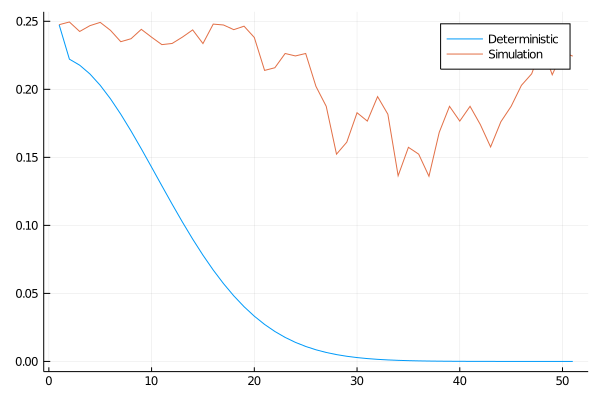

In [94]:
plot(H_series, label = "Deterministic")
plot!(H_sim, label = "Simulation")

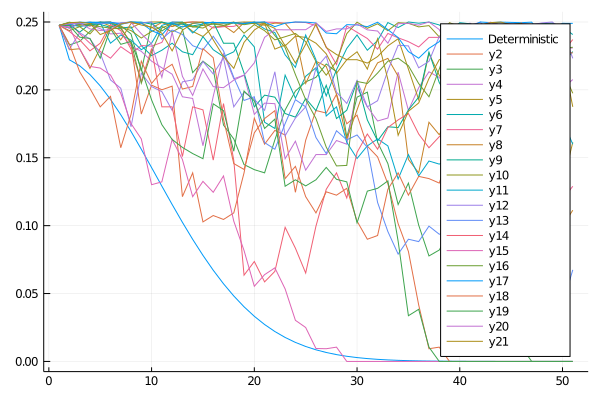

In [102]:
plot(H_series, label = "Deterministic")
for i in 1:20
    d = d_m
    H = heterozygosity(d_m)
    H_sim = [H]
    for year in 1:50
        d = life_cycle(d)
        H = heterozygosity(d)
        push!(H_sim,H)
    end   
    plot!(H_sim)
end
current()

In [103]:
d_large = make_deme(nn*10,1,α,nn*10,α/2)
d_m_large = deepcopy(d_large)
H_large = heterozygosity(d_large)
H_sim_large = [H_large]
H_series_large = [H_large]
for i in 1:50
    H_large = det_het(H_large,i,nn*10)
    push!(H_series_large,H_large)
end


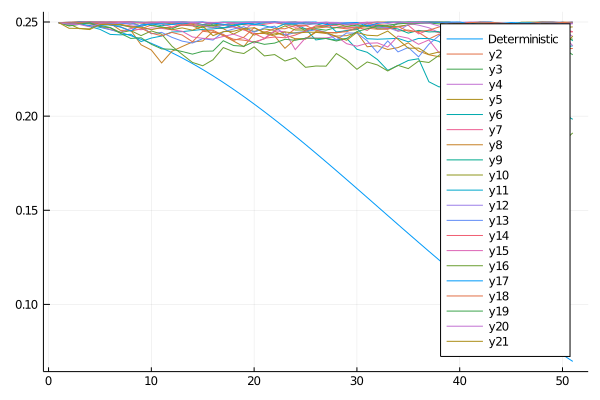

In [104]:
plot(H_series_large, label = "Deterministic")
for i in 1:20
    d_large = d_m_large
    H_large = heterozygosity(d_m_large)
    H_sim_large = [H_large]
    for year in 1:50
        d_large = life_cycle(d_large)
        H_large = heterozygosity(d_large)
        push!(H_sim_large,H_large)
    end   
    plot!(H_sim_large)
end
current()

In [107]:
d_small = make_deme(10,1,α,10,α/2)
d_m_small = deepcopy(d_small)
H_small = heterozygosity(d_small)
H_sim_small = [H_small]
H_series_small = [H_small]
for i in 1:50
    H_small = det_het(H_small,i,10)
    push!(H_series_small,H_small)
end

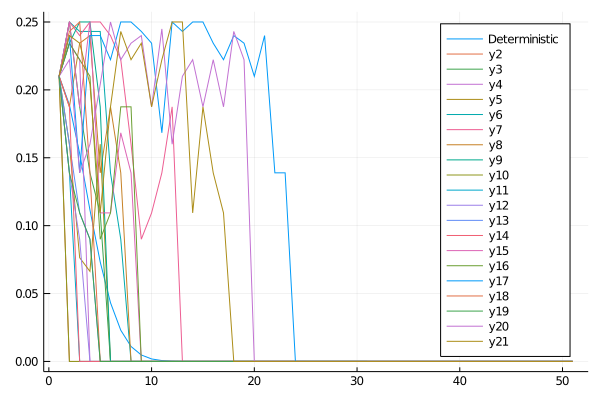

In [108]:
plot(H_series_small, label = "Deterministic")
for i in 1:20
    d_small = d_m_small
    H_small = heterozygosity(d_m_small)
    H_sim_small = [H_small]
    for year in 1:50
        d_small = life_cycle(d_small)
        H_small = heterozygosity(d_small)
        push!(H_sim_small,H_small)
    end   
    plot!(H_sim_small)
end
current()